## Notebook 2: Prepare FPV Dataset

In [2]:
# Cell 1: Setup
import os
import cv2
import json
import shutil
from pathlib import Path
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

# YOUR EXACT PATHS
FPV_INPUT = "/data/omar/RESEARCH/crosswalk-cctv/data/FPVCrosswalk2025"
FPV_OUTPUT = "/data/omar/RESEARCH/crosswalk-cctv/data/fpv_processed"

print(f" Input:  {FPV_INPUT}")
print(f" Output: {FPV_OUTPUT}")

 Input:  /data/omar/RESEARCH/crosswalk-cctv/data/FPVCrosswalk2025
 Output: /data/omar/RESEARCH/crosswalk-cctv/data/fpv_processed


In [3]:
# Cell 2: Explore FPV dataset structure (CORRECTED)
fpv_dir = Path(FPV_INPUT)

print(" FPV Dataset Structure:")
print()

# Fine-tuning seed images
seed_dir = fpv_dir / "Fine-tuning seed images"
if seed_dir.exists():
    print(f" Fine-tuning seed images/")
    num_files = len([f for f in seed_dir.iterdir() if f.is_file()])
    print(f"   {num_files} files")
    print()

# Real-world dataset
real_world_dir = fpv_dir / "Real-world dataset"
if real_world_dir.exists():
    print(f" Real-world dataset/")
    for condition_dir in sorted(real_world_dir.iterdir()):
        if condition_dir.is_dir():
            images_dir = condition_dir / "images"
            masks_dir = condition_dir / "masks"
            
            n_images = len(list(images_dir.glob('*.*'))) if images_dir.exists() else 0
            n_masks = len(list(masks_dir.glob('*.*'))) if masks_dir.exists() else 0
            
            print(f"    {condition_dir.name}/")
            print(f"      images/  {n_images} files")
            print(f"      masks/   {n_masks} files")
    print()

# Synthetic dataset
synthetic_dir = fpv_dir / "Synthetic dataset"
if synthetic_dir.exists():
    print(f" Synthetic dataset/")
    for condition_dir in sorted(synthetic_dir.iterdir()):
        if condition_dir.is_dir():
            images_dir = condition_dir / "images"
            masks_dir = condition_dir / "masks"
            
            n_images = len(list(images_dir.glob('*.*'))) if images_dir.exists() else 0
            n_masks = len(list(masks_dir.glob('*.*'))) if masks_dir.exists() else 0
            
            print(f"    {condition_dir.name}/")
            print(f"      images/  {n_images} files")
            print(f"      masks/   {n_masks} files")
    print()

 FPV Dataset Structure:

 Fine-tuning seed images/
   150 files

 Real-world dataset/
    cloudy/
      images/  60 files
      masks/   60 files
    night/
      images/  60 files
      masks/   60 files
    rainy/
      images/  60 files
      masks/   60 files
    sunny/
      images/  120 files
      masks/   120 files

 Synthetic dataset/
    cloudy/
      images/  300 files
      masks/   300 files
    night/
      images/  300 files
      masks/   300 files
    rainy/
      images/  300 files
      masks/   300 files
    standard/
      images/  1500 files
      masks/   1500 files
    sunny/
      images/  600 files
      masks/   600 files



In [7]:
# Cell 3: Find all image-mask pairs 
def find_all_pairs(root_dir):
    """
    Find all image-mask pairs in the FPV dataset
    Masks have pattern: {image_stem}_mask.jpg
    """
    pairs = []
    root = Path(root_dir)
    
    # 1. Real-world dataset
    real_world_dir = root / "Real-world dataset"
    if real_world_dir.exists():
        print(" Scanning Real-world dataset...")
        for condition_dir in real_world_dir.iterdir():
            if not condition_dir.is_dir():
                continue
            
            images_dir = condition_dir / "images"
            masks_dir = condition_dir / "masks"
            
            if not images_dir.exists() or not masks_dir.exists():
                continue
            
            # Get all image files
            image_files = [f for f in images_dir.iterdir() 
                          if f.is_file() and not f.name.startswith('.')]
            
            print(f"   {condition_dir.name}/images/: {len(image_files)} files")
            
            matched = 0
            for img_path in image_files:
                # Mask pattern: {stem}_mask.jpg
                mask_name = f"{img_path.stem}_mask.jpg"
                mask_path = masks_dir / mask_name
                
                if mask_path.exists():
                    category = f"realworld_{condition_dir.name}"
                    pairs.append((img_path, mask_path, category))
                    matched += 1
            
            print(f"      Matched {matched} pairs")
    
    # 2. Synthetic dataset
    synthetic_dir = root / "Synthetic dataset"
    if synthetic_dir.exists():
        print("\n Scanning Synthetic dataset...")
        for condition_dir in synthetic_dir.iterdir():
            if not condition_dir.is_dir():
                continue
            
            images_dir = condition_dir / "images"
            masks_dir = condition_dir / "masks"
            
            if not images_dir.exists() or not masks_dir.exists():
                continue
            
            image_files = [f for f in images_dir.iterdir() 
                          if f.is_file() and not f.name.startswith('.')]
            
            print(f"   {condition_dir.name}/images/: {len(image_files)} files")
            
            matched = 0
            for img_path in image_files:
                # Mask pattern: {stem}_mask.jpg
                mask_name = f"{img_path.stem}_mask.jpg"
                mask_path = masks_dir / mask_name
                
                if mask_path.exists():
                    category = f"synthetic_{condition_dir.name}"
                    pairs.append((img_path, mask_path, category))
                    matched += 1
            
            print(f"      Matched {matched} pairs")
    
    return pairs

# Find all pairs
print(" Searching for image-mask pairs...")
print()
pairs = find_all_pairs(FPV_INPUT)
print()
print(f"{'='*60}")
print(f" Found {len(pairs)} image-mask pairs TOTAL")
print(f"{'='*60}")
print()

# Count by category
from collections import Counter
categories = [cat for _, _, cat in pairs]
category_counts = Counter(categories)

print(" Breakdown by category:")
for cat, count in sorted(category_counts.items()):
    print(f"  {cat}: {count}")

 Searching for image-mask pairs...

 Scanning Real-world dataset...
   rainy/images/: 60 files
      Matched 60 pairs
   cloudy/images/: 60 files
      Matched 60 pairs
   night/images/: 60 files
      Matched 60 pairs
   sunny/images/: 120 files
      Matched 120 pairs

 Scanning Synthetic dataset...
   rainy/images/: 300 files
      Matched 300 pairs
   cloudy/images/: 300 files
      Matched 300 pairs
   standard/images/: 1500 files
      Matched 1500 pairs
   night/images/: 300 files
      Matched 300 pairs
   sunny/images/: 600 files
      Matched 600 pairs

 Found 3300 image-mask pairs TOTAL

 Breakdown by category:
  realworld_cloudy: 60
  realworld_night: 60
  realworld_rainy: 60
  realworld_sunny: 120
  synthetic_cloudy: 300
  synthetic_night: 300
  synthetic_rainy: 300
  synthetic_standard: 1500
  synthetic_sunny: 600


In [8]:
# Cell 4: Show sample filenames
print(" Sample pairs (10 random samples):")
print()

import random
samples = random.sample(pairs, min(10, len(pairs)))

for i, (img_path, mask_path, category) in enumerate(samples, 1):
    print(f"{i}. Category: {category}")
    print(f"   Image: {img_path.name}")
    print(f"   Mask:  {mask_path.name}")
    print()

 Sample pairs (10 random samples):

1. Category: synthetic_rainy
   Image: img_rainy_279.jpg
   Mask:  img_rainy_279_mask.jpg

2. Category: synthetic_standard
   Image: img_std_364.jpg
   Mask:  img_std_364_mask.jpg

3. Category: synthetic_standard
   Image: img_std_1086.jpg
   Mask:  img_std_1086_mask.jpg

4. Category: synthetic_sunny
   Image: img_sunny_249.jpg
   Mask:  img_sunny_249_mask.jpg

5. Category: synthetic_standard
   Image: img_std_535.jpg
   Mask:  img_std_535_mask.jpg

6. Category: synthetic_sunny
   Image: img_sunny_459.jpg
   Mask:  img_sunny_459_mask.jpg

7. Category: realworld_night
   Image: 20250209_181818.mp4_000001097 (Custom).jpg
   Mask:  20250209_181818.mp4_000001097 (Custom)_mask.jpg

8. Category: synthetic_standard
   Image: img_std_253.jpg
   Mask:  img_std_253_mask.jpg

9. Category: realworld_cloudy
   Image: 20241212_135457.mp4_000009465 (Custom).jpg
   Mask:  20241212_135457.mp4_000009465 (Custom)_mask.jpg

10. Category: realworld_night
   Image: 202502

 Visualizing samples from each category:
     CHECK IF MASKS LOOK CORRECT!



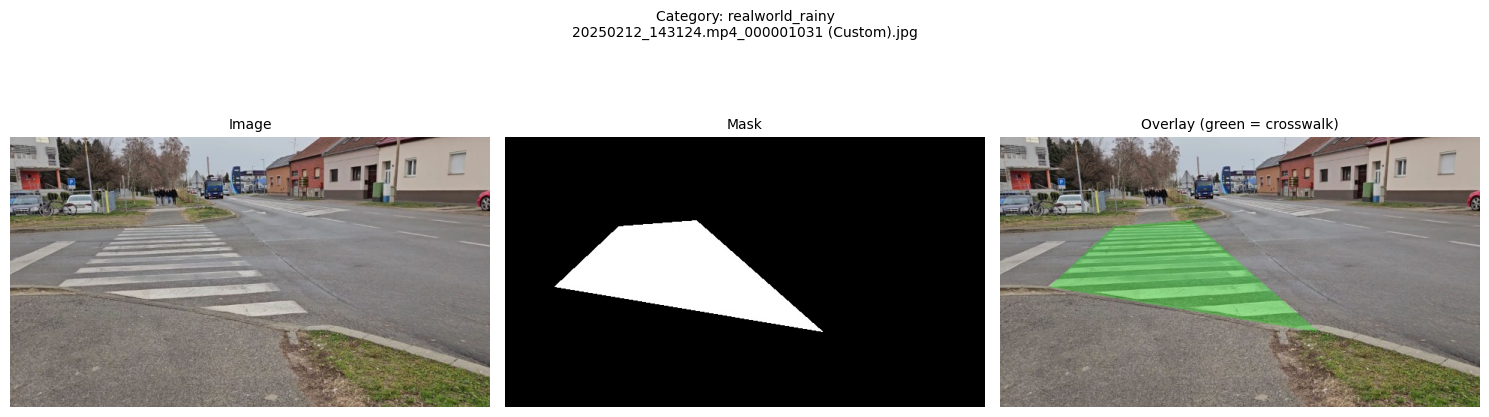

Image size: (360, 640, 3)
Mask coverage: 11.1%
Mask values: min=0, max=255



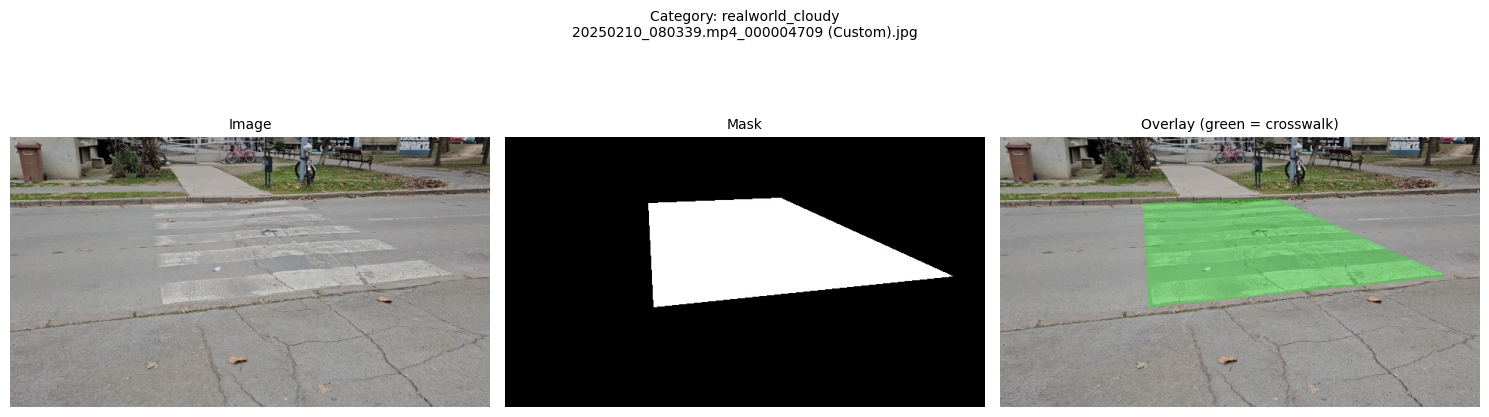

Image size: (360, 640, 3)
Mask coverage: 16.5%
Mask values: min=0, max=255



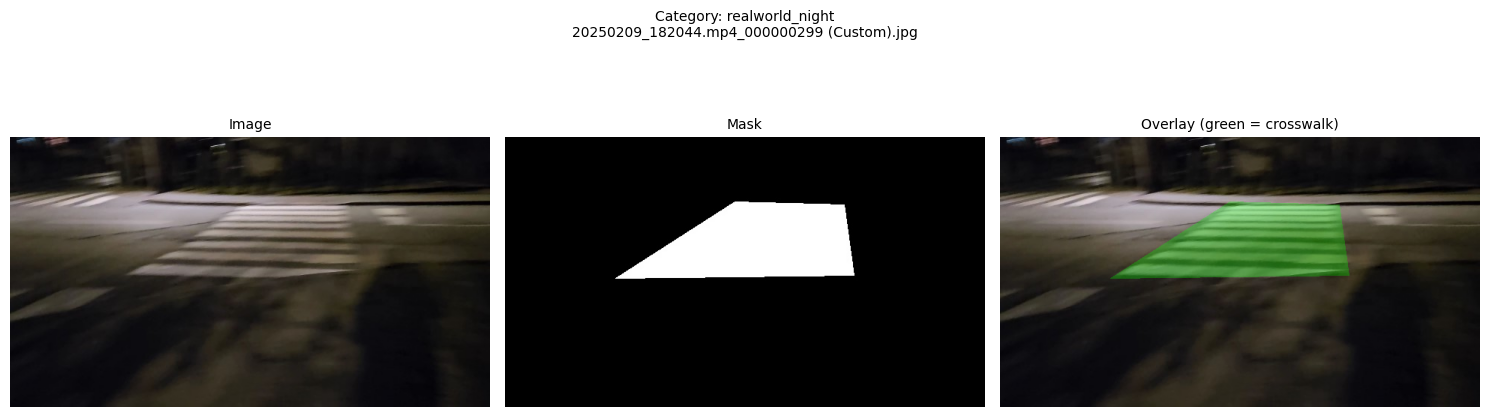

Image size: (360, 640, 3)
Mask coverage: 10.0%
Mask values: min=0, max=255



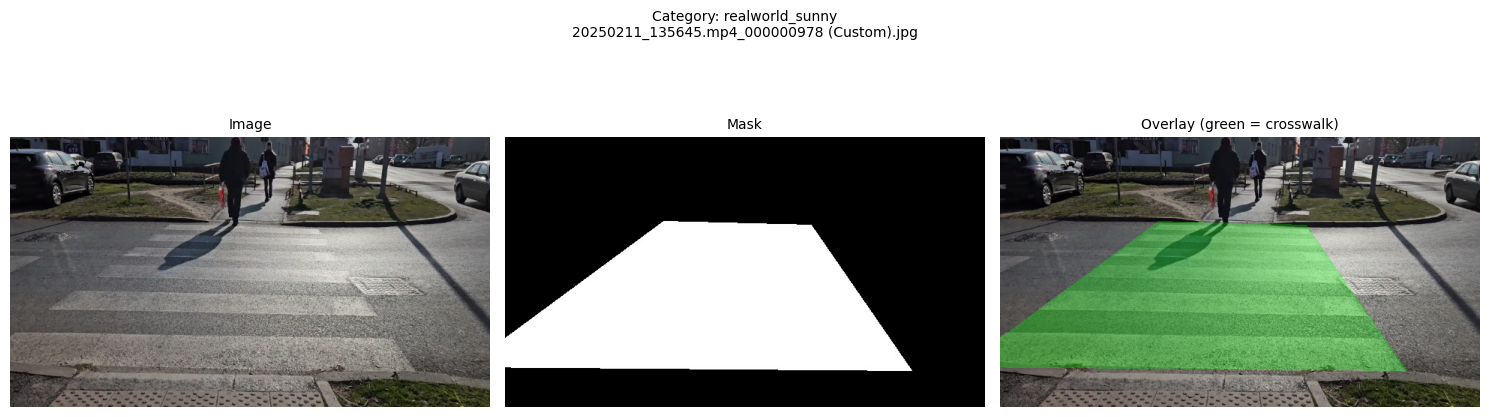

Image size: (360, 640, 3)
Mask coverage: 33.3%
Mask values: min=0, max=255



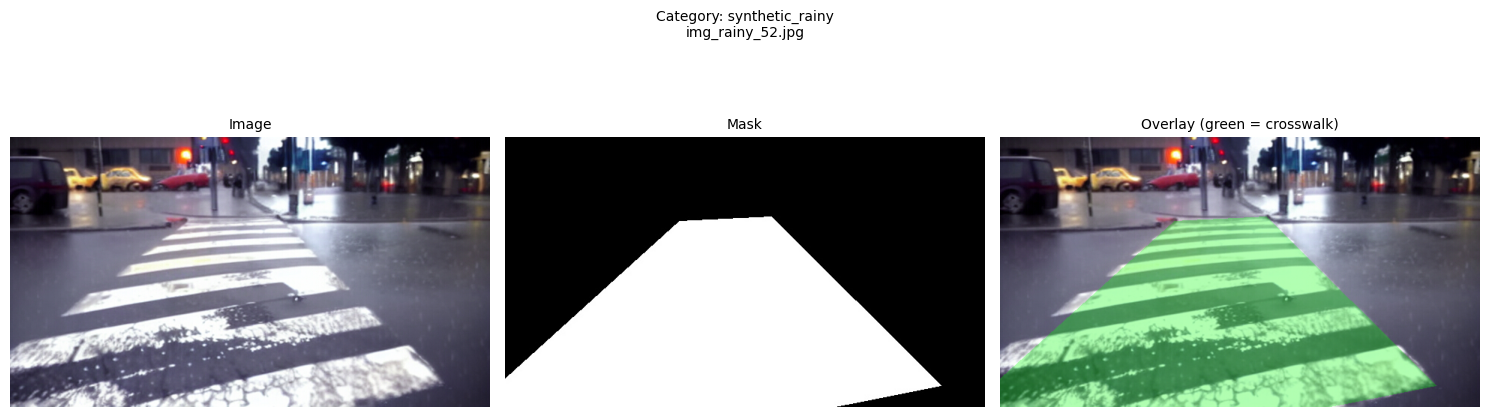

Image size: (360, 640, 3)
Mask coverage: 40.8%
Mask values: min=0, max=255



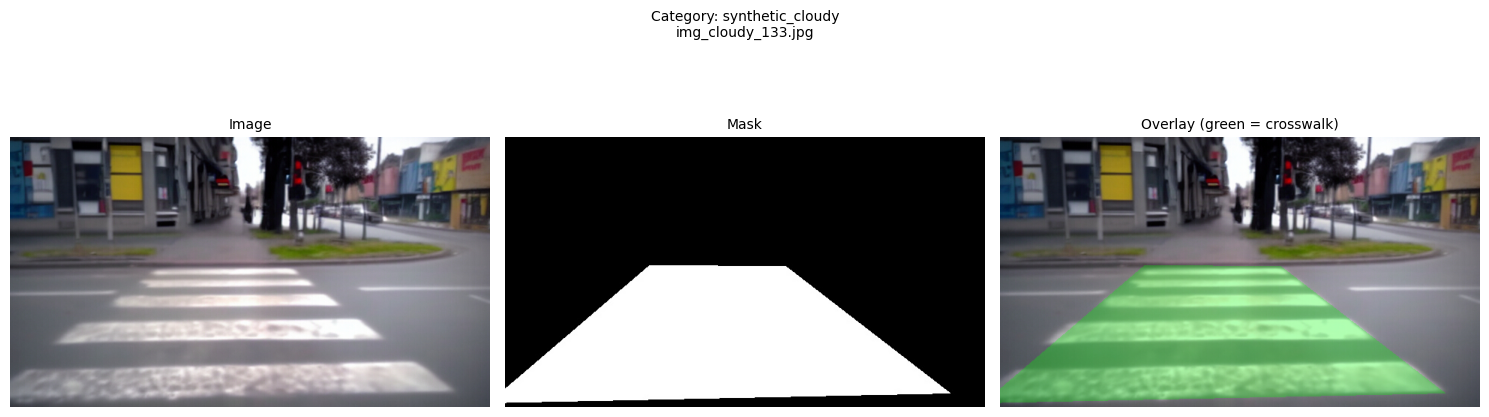

Image size: (360, 640, 3)
Mask coverage: 30.6%
Mask values: min=0, max=255



In [9]:
# Cell 5: Visualize samples (CHECK MASKS ARE CORRECT!)
def visualize_pair(img_path, mask_path, category):
    """Show image + mask side by side"""
    # Read
    img = cv2.imread(str(img_path))
    if img is None:
        print(f" Could not read image: {img_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f" Could not read mask: {mask_path}")
        return
    
    # Create overlay
    overlay = img.copy()
    overlay[mask > 127] = [0, 255, 0]  # Green where mask is white
    blended = cv2.addWeighted(img, 0.7, overlay, 0.3, 0)
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img)
    axes[0].set_title(f"Image", fontsize=10)
    axes[0].axis('off')
    
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title(f"Mask", fontsize=10)
    axes[1].axis('off')
    
    axes[2].imshow(blended)
    axes[2].set_title("Overlay (green = crosswalk)", fontsize=10)
    axes[2].axis('off')
    
    plt.suptitle(f"Category: {category}\n{img_path.name}", fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # Print stats
    mask_coverage = np.sum(mask > 127) / mask.size * 100
    print(f"Image size: {img.shape}")
    print(f"Mask coverage: {mask_coverage:.1f}%")
    print(f"Mask values: min={mask.min()}, max={mask.max()}")
    print()

# Show samples from different categories
print(" Visualizing samples from each category:")
print("     CHECK IF MASKS LOOK CORRECT!")
print()

# Sample 1 from each unique category
categories_shown = set()
samples_to_show = []

for img_path, mask_path, category in pairs:
    if category not in categories_shown:
        samples_to_show.append((img_path, mask_path, category))
        categories_shown.add(category)

# Show up to 6 samples (so it fits on screen)
for img_path, mask_path, category in samples_to_show[:6]:
    visualize_pair(img_path, mask_path, category)

In [10]:
# Cell 6: Split into train/val/test
np.random.seed(42)
indices = np.random.permutation(len(pairs))

# 80% train, 10% val, 10% test
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1
n_train = int(len(pairs) * train_ratio)
n_val = int(len(pairs) * val_ratio)

train_indices = indices[:n_train]
val_indices = indices[n_train:n_train + n_val]
test_indices = indices[n_train + n_val:]

splits = {
    'train': train_indices,
    'val': val_indices,
    'test': test_indices
}

print(" Dataset Split:")
print(f"  Train: {len(train_indices)} samples ({len(train_indices)/len(pairs)*100:.1f}%)")
print(f"  Val:   {len(val_indices)} samples ({len(val_indices)/len(pairs)*100:.1f}%)")
print(f"  Test:  {len(test_indices)} samples ({len(test_indices)/len(pairs)*100:.1f}%)")
print()
print(f"Total: {len(pairs)} pairs")

 Dataset Split:
  Train: 2640 samples (80.0%)
  Val:   330 samples (10.0%)
  Test:  330 samples (10.0%)

Total: 3300 pairs


In [11]:
# Cell 7: Copy files to organized structure
output_dir = Path(FPV_OUTPUT)

print(" Copying files to output structure...")
print(f" Output: {output_dir}")
print()
print("This may take a few minutes...")
print()

for split_name, split_indices in splits.items():
    print(f"Processing {split_name} split ({len(split_indices)} samples)...")
    
    # Create directories
    img_out_dir = output_dir / split_name / 'images'
    mask_out_dir = output_dir / split_name / 'masks'
    img_out_dir.mkdir(parents=True, exist_ok=True)
    mask_out_dir.mkdir(parents=True, exist_ok=True)
    
    for idx in tqdm(split_indices):
        img_path, mask_path, category = pairs[idx]
        
        # Create unique filename: category_index_originalname
        # This ensures no duplicates even if original names collide
        new_name = f"{category}_{idx:05d}_{img_path.name}"
        mask_name = f"{category}_{idx:05d}_{img_path.stem}_mask.png"
        
        # Copy image
        shutil.copy(img_path, img_out_dir / new_name)
        
        # Copy mask and ensure binary (0 or 255)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        
        if mask is not None:
            # Binarize: anything > 127 becomes 255, rest becomes 0
            mask_binary = (mask > 127).astype(np.uint8) * 255
            cv2.imwrite(str(mask_out_dir / mask_name), mask_binary)
        else:
            print(f"    Could not read mask: {mask_path}")
    
    print(f"   {split_name}: {len(split_indices)} samples copied")
    print()

print(" All files copied successfully!")

 Copying files to output structure...
 Output: /data/omar/RESEARCH/crosswalk-cctv/data/fpv_processed

This may take a few minutes...

Processing train split (2640 samples)...


  0%|          | 0/2640 [00:00<?, ?it/s]

   train: 2640 samples copied

Processing val split (330 samples)...


  0%|          | 0/330 [00:00<?, ?it/s]

   val: 330 samples copied

Processing test split (330 samples)...


  0%|          | 0/330 [00:00<?, ?it/s]

   test: 330 samples copied

 All files copied successfully!


In [12]:
# Cell 8: Save summary
summary = {
    'total_samples': len(pairs),
    'train': len(train_indices),
    'val': len(val_indices),
    'test': len(test_indices),
    'categories': dict(category_counts),
    'split_seed': 42,
}

summary_path = output_dir / 'dataset_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"📄 Summary saved: {summary_path}")
print()
print("="*60)
print(" Dataset Summary")
print("="*60)
print(json.dumps(summary, indent=2))

📄 Summary saved: /data/omar/RESEARCH/crosswalk-cctv/data/fpv_processed/dataset_summary.json

 Dataset Summary
{
  "total_samples": 3300,
  "train": 2640,
  "val": 330,
  "test": 330,
  "categories": {
    "realworld_rainy": 60,
    "realworld_cloudy": 60,
    "realworld_night": 60,
    "realworld_sunny": 120,
    "synthetic_rainy": 300,
    "synthetic_cloudy": 300,
    "synthetic_standard": 1500,
    "synthetic_night": 300,
    "synthetic_sunny": 600
  },
  "split_seed": 42
}


In [13]:
# Cell 9: Final verification
print("="*60)
print(" Verifying Output Structure")
print("="*60)
print()

all_good = True

for split in ['train', 'val', 'test']:
    img_dir = output_dir / split / 'images'
    mask_dir = output_dir / split / 'masks'
    
    n_images = len(list(img_dir.glob('*.*')))
    n_masks = len(list(mask_dir.glob('*.*')))
    
    print(f"{split.upper()}:")
    print(f"   Images: {n_images}")
    print(f"   Masks:  {n_masks}")
    
    if n_images != n_masks:
        print(f"   MISMATCH!")
        all_good = False
    else:
        print(f"   Counts match!")
    print()

if all_good:
    print(" All splits verified successfully!")
else:
    print("  Some issues detected, check above")

# Show sample output filenames
print()
print(" Sample output filenames (train):")
train_images = sorted(list((output_dir / 'train' / 'images').glob('*.*')))[:5]
for img in train_images:
    print(f"  {img.name}")

 Verifying Output Structure

TRAIN:
   Images: 2640
   Masks:  2640
   Counts match!

VAL:
   Images: 330
   Masks:  330
   Counts match!

TEST:
   Images: 330
   Masks:  330
   Counts match!

 All splits verified successfully!

 Sample output filenames (train):
  realworld_cloudy_00060_20250210_080339.mp4_000004709 (Custom).jpg
  realworld_cloudy_00061_20241212_134549.mp4_000001485 (Custom).jpg
  realworld_cloudy_00062_20250210_075956.mp4_000001430 (Custom).jpg
  realworld_cloudy_00063_20241212_135426.mp4_000000892 (Custom).jpg
  realworld_cloudy_00065_20250210_080144.mp4_000014871 (Custom).jpg


In [14]:
# Cell 10: Complete Summary & Next Steps
print()
print("="*60)
print("🎉 PHASE 1 DATA PREPARATION COMPLETE!")
print("="*60)
print()

print(" WHAT WE HAVE NOW:")
print()
print("1.  CCTV Frames: 175 frames")
print("    /data/omar/RESEARCH/crosswalk-cctv/data/cctv_frames/")
print("    Distribution: 73.7% night, 26.3% day")
print()

print("2.  FPV Dataset: 3,300 pairs")
print(f"    {output_dir}/")
print(f"    Train: {len(train_indices)} samples")
print(f"    Val:   {len(val_indices)} samples")
print(f"    Test:  {len(test_indices)} samples")
print()
print("   Categories:")
for cat, count in sorted(category_counts.items()):
    print(f"     • {cat}: {count}")
print()

print("="*60)
print(" NEXT STEPS:")
print("="*60)
print()
print("3.  Notebook 03: Visualize both datasets together")
print("   → Compare FPV vs CCTV viewpoints")
print()
print("4.  Notebook 04: Train Stage 1 (FPV Pretraining)")
print("   → Train segmentation model on FPV dataset")
print("   → This will take 1-2 hours on GPU")
print()
print("5.  Notebook 05: Test FPV model on CCTV frames")
print("   → See the domain gap (FPV → CCTV)")
print("   → Measure IoU, visualize predictions")
print()
print("6.  Notebook 06: Stage 2 - Geometric Self-Supervision")
print("   → Adapt model to CCTV using geometry")
print("   → The NOVEL research contribution!")
print()

print("="*60)
print(" Storage Info:")
print("="*60)
# Calculate approximate storage
cctv_storage = 175 * 0.5  # MB
fpv_storage = len(pairs) * 1.0  # MB (image + mask)
print(f"CCTV frames: ~{cctv_storage:.0f} MB")
print(f"FPV dataset: ~{fpv_storage:.0f} MB")
print(f"Total data: ~{cctv_storage + fpv_storage:.0f} MB")
print()
print(" Ready to start training!")


🎉 PHASE 1 DATA PREPARATION COMPLETE!

 WHAT WE HAVE NOW:

1.  CCTV Frames: 175 frames
    /data/omar/RESEARCH/crosswalk-cctv/data/cctv_frames/
    Distribution: 73.7% night, 26.3% day

2.  FPV Dataset: 3,300 pairs
    /data/omar/RESEARCH/crosswalk-cctv/data/fpv_processed/
    Train: 2640 samples
    Val:   330 samples
    Test:  330 samples

   Categories:
     • realworld_cloudy: 60
     • realworld_night: 60
     • realworld_rainy: 60
     • realworld_sunny: 120
     • synthetic_cloudy: 300
     • synthetic_night: 300
     • synthetic_rainy: 300
     • synthetic_standard: 1500
     • synthetic_sunny: 600

 NEXT STEPS:

3.  Notebook 03: Visualize both datasets together
   → Compare FPV vs CCTV viewpoints

4.  Notebook 04: Train Stage 1 (FPV Pretraining)
   → Train segmentation model on FPV dataset
   → This will take 1-2 hours on GPU

5.  Notebook 05: Test FPV model on CCTV frames
   → See the domain gap (FPV → CCTV)
   → Measure IoU, visualize predictions

6.  Notebook 06: Stage 2 -